# Constrain the ensemble

Using:
- temperature
- ocean heat uptake
- CO2 concentration

In [26]:
from climateforcing.utils import check_and_download
from matplotlib.lines import Line2D
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np

In [2]:
SAMPLES = 100000

In [3]:
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 9
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 150

## Get observational data

In [4]:
# AR6 temperature dataset
check_and_download(
    "https://github.com/chrisroadmap/ar6/raw/main/data_input/observations/AR6%20FGD%20assessment%20time%20series%20-%20GMST%20and%20GSAT.xlsx",
    "../data_input/AR6_FGD_assessment_time_series_-_GMST_and_GSAT.xlsx"
)

1.2563235294117647

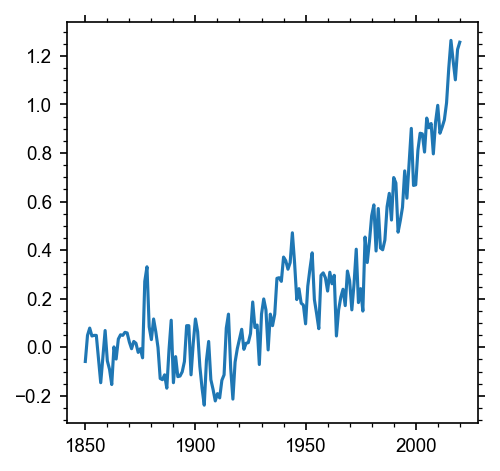

In [5]:
xl = pd.read_excel('../data_input/AR6_FGD_assessment_time_series_-_GMST_and_GSAT.xlsx', skiprows=1, skipfooter=28, engine="openpyxl")
temp_gmst=xl['4-set mean'].values
temp_year=xl['Unnamed: 0'].values
pl.plot(temp_year, temp_gmst)

temp_gmst[-1]

In [6]:
# OHC dataset
check_and_download(
    "https://github.com/chrisroadmap/ar6/raw/main/data_input/observations/AR6_OHC_ensemble_FGDprelim.csv",
    "../data_input/AR6_OHC_ensemble_FGDprelim.csv"
)

In [7]:
OHC_df = pd.read_csv("../data_input/AR6_OHC_ensemble_FGDprelim.csv", skiprows=1)
OHUobs = OHC_df['Central Estimate Full-depth'].values
OHUyears = OHC_df['Year'].values
OHU90 = OHC_df['Full-depth Uncertainty (1-sigma)'].values

In [8]:
# rcmip concentrations files
check_and_download(
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv',
    '../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv'
)

In [9]:
conc_all = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
co2_obs = conc_all[(conc_all['Scenario']=='ssp245')&(conc_all['Region']=='World')&(conc_all.Variable.str.endswith('CO2'))].loc[:,'1750':'2018'].values.squeeze()

## Constraining starts here

In [10]:
C_CO2 = np.load('../data_output_large/C_CO2_unconstrained.npy')
T = np.load('../data_output_large/T_unconstrained.npy')
OHU = np.load('../data_output_large/OHU_unconstrained.npy')
AF = np.load('../data_output_large/AF_unconstrained.npy')

In [11]:
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

In [12]:
## simple criterion: RMSE of temperature 1850-2014 < 0.135
rmse_temp = np.zeros((SAMPLES))
for i in range(SAMPLES):
    rmse_temp[i] = rmse(temp_gmst[:165], (T[100:265,i]-np.mean(T[100:151,i], axis=0)))
accept_temp=(rmse_temp<0.135)
print(np.sum(accept_temp))
valid_temp = np.arange(SAMPLES, dtype=int)[accept_temp]

31009


In [13]:
accept_ohu = np.logical_and(
    ((OHUobs[-1]-OHUobs[0]) - np.sqrt(OHU90[0]**2+OHU90[-1]**2)) < 0.90*(OHU[268,:]-OHU[221,:])*1e-21,
    0.90*(OHU[268,:]-OHU[221,:])*1e-21 < ((OHUobs[-1]-OHUobs[0]) + np.sqrt(OHU90[0]**2+OHU90[-1]**2))
)
valid_ohu = np.arange(SAMPLES, dtype=int)[accept_ohu]
print(np.sum(accept_ohu))

31631


In [14]:
accept_co2 = np.logical_and( (co2_obs[264] - 0.36) < C_CO2[264], C_CO2[264] < (co2_obs[264] + 0.36) )
print(np.sum(accept_co2))

2177


In [15]:
accept_ssp245 = accept_temp * accept_ohu * accept_co2
print(np.sum(accept_ssp245))

396


In [21]:
# Also get SSP2-4.5
ssp245 = pd.read_csv('../data_output/ssp245.csv', index_col=0)

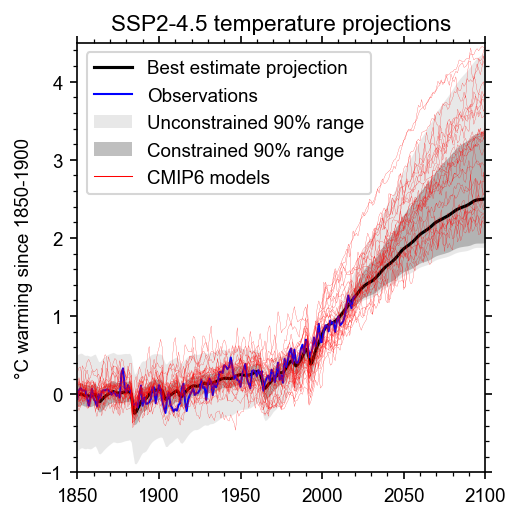

In [31]:
pl.fill_between(
    np.arange(1850, 2101),
    np.percentile(T[100:,:]-np.mean(T[245:265,:], axis=0) + 0.85, 5, axis=1),
    np.percentile(T[100:,:]-np.mean(T[245:265,:], axis=0) + 0.85, 95, axis=1), 
    color='lightgray', lw=0, alpha=0.5,
    label='Unconstrained 90% range'
)
pl.fill_between(
    np.arange(1850, 2101),
    np.percentile(T[100:,accept_ssp245]-np.mean(T[245:265,accept_ssp245], axis=0) + 0.85, 5, axis=1),
    np.percentile(T[100:,accept_ssp245]-np.mean(T[245:265,accept_ssp245], axis=0) + 0.85, 95, axis=1), 
    color='gray', lw=0, alpha=0.5,
    label='Constrained 90% range'
)
pl.plot(
    np.arange(1850, 2101), 
    np.percentile(T[100:,accept_ssp245]-np.mean(T[245:265,accept_ssp245], axis=0) + 0.85, 50, axis=1),
    color='k',
    label='Best estimate projection'
)
pl.plot(np.arange(1850, 2021), temp_gmst, color='blue', label='Observations', lw=1.0)

pl.plot(np.arange(1850, 2101), ssp245.T, color='red', lw=0.1)

line = Line2D([0], [0], label='CMIP6 models', color='red', lw=0.5)

pl.title('SSP2-4.5 temperature projections')
pl.ylabel('°C warming since 1850-1900')
pl.xlim(1850, 2100)
pl.ylim(-1, 4.5)

handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([line])
pl.legend(handles=handles, loc='upper left')

pl.savefig('../figures/constraining.png')
pl.savefig('../figures/constraining.pdf')

pl.tight_layout()